In [1]:
import os

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TFHUB_CACHE_DIR"]="tfhub_modules"

torch.manual_seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from allennlp.modules.elmo import batch_to_ids

class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41

  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT

  def __init__(self, n_items=0):
    data = pd.read_csv(self.FILENAME)
    if n_items > 0:
      data = data.iloc[0:n_items,:]
    data["text"] = data["SIT"]
    data["emotion"] = data["Field1"]
    for emotion in self.get_classes():
      data.loc[data["emotion"] == emotion, "emotion_int"] = self.get_classes_dict()[emotion]
    self.X = np.array(batch_to_ids(data["text"].values).tolist())
    self.y = data["emotion_int"].values

In [3]:
isear_dataset = ISEARDataset()
# isear_dataset = ISEARDataset(200)
X_train, X_test, y_train, y_test = train_test_split(isear_dataset.X, isear_dataset.y, test_size=0.3, random_state=isear_dataset.RANDOM_STATE, stratify=isear_dataset.y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=isear_dataset.RANDOM_STATE, stratify=y_train)

print("X_train.shape: (%d, %d, %d)" % X_train.shape)
print("y_train.shape: (%d)" % y_train.shape)

print("X_valid.shape: (%d, %d, %d)" % X_valid.shape)
print("y_valid.shape: (%d)" % y_valid.shape)

print("X_test.shape: (%d, %d, %d)" % X_test.shape)
print("y_test.shape: (%d)" % y_test.shape)

X_train.shape: (4292, 889, 50)
y_train.shape: (4292)
X_valid.shape: (1074, 889, 50)
y_valid.shape: (1074)
X_test.shape: (2300, 889, 50)
y_test.shape: (2300)


In [4]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
n_classes = len(labels)
print("class dictionary: %s" % dic)
print("class labels: %s" % labels)
print("number of bins: %s" % n_classes)

class dictionary: {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
class labels: ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
number of bins: 7


bins: [0, 1, 2, 3, 4, 5, 6, 7]


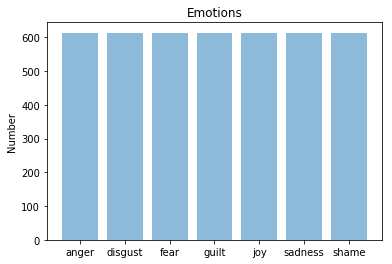

In [5]:
bins = list(range(0, n_classes + 1))
print("bins:", bins)
hist, _ = np.histogram(y_train, bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

In [6]:
from torch import autograd

def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
    target = one_hot.scatter_(1, labels.data, 1)
    
    target = autograd.Variable(target)
        
    return target
  
y = torch.LongTensor(y_train).view(-1, 1, 1, 1)
print("y.shape:", y.shape)
y_onehot = make_one_hot(y, C=7)
print("y_onehot.shape:", y_onehot.shape)

y.shape: torch.Size([4292, 1, 1, 1])
y_onehot.shape: torch.Size([4292, 7, 1, 1])


In [34]:
import torch
from torch.utils import data

class ISEAR_Tensor_Dataset(data.TensorDataset):
  
  def __init__(self, text, emotion, num_class=2):
    X = torch.Tensor(text.astype('float'))
    y = torch.LongTensor(emotion).view(-1, 1, 1, 1)
    y_onehot = make_one_hot(y, num_class)
    y_onehot = y_onehot.view(y_onehot.shape[0], y_onehot.shape[1])
    tensors = []
    tensors.append(X)
    tensors.append(y_onehot)
    super().__init__(*tensors)

In [35]:
train_dataset = ISEAR_Tensor_Dataset(X_train, y_train, num_class=7)
valid_dataset = ISEAR_Tensor_Dataset(X_valid, y_valid, num_class=7)
test_dataset = ISEAR_Tensor_Dataset(X_test, y_test, num_class=7)

In [36]:
print("train_dataset.tensors[0].shape:", train_dataset.tensors[0].shape)
print("train_dataset.tensors[1].shape:", train_dataset.tensors[1].shape)

train_dataset.tensors[0].shape: torch.Size([4292, 889, 50])
train_dataset.tensors[1].shape: torch.Size([4292, 7])


In [37]:
print("train_dataset length:", len(train_dataset))
print("valid_dataset length:", len(valid_dataset))
print("test_dataset length:", len(test_dataset))

train_dataset length: 4292
valid_dataset length: 1074
test_dataset length: 2300


In [38]:
batch_size = 50

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Test Elmo Embedder

In [12]:
from allennlp.commands.elmo import ElmoEmbedder


options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

elmo_embedder = ElmoEmbedder(options_file, weight_file)
tokens = ["I", "ate", "an", "apple", "for", "breakfast"]
vectors = elmo_embedder.embed_sentence(tokens)

import scipy
vectors2 = elmo_embedder.embed_sentence(["I", "ate", "a", "carrot", "for", "breakfast"])
scipy.spatial.distance.cosine(vectors[2][3], vectors2[2][3]) # cosine distance between "apple" and "carrot" in the last layer


/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/allennlp/commands/find_learning_rate.py:54: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/david/anaconda3/envs/tf36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/david/anaconda3/envs/tf36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/david/anaconda3/envs/tf36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/david/anaconda3/envs/tf36/

0.15912526845932007

In [13]:
print("vectors.shape:", vectors.shape)
print("vectors2.shape:", vectors2.shape)

print("vectors[2][3].shape:", vectors[2][3].shape)
print("vectors2[2][3].shape:", vectors2[2][3].shape)

vectors.shape: (3, 6, 256)
vectors2.shape: (3, 6, 256)
vectors[2][3].shape: (256,)
vectors2[2][3].shape: (256,)


### Load Elmo

In [14]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0)
elmo = elmo.to(device)

01/18/2019 11:44:00 - INFO - allennlp.modules.elmo -   Initializing ELMo


### Test Elmo Module

In [15]:
shape = train_dataset[0][0].shape
experiment_X_train = train_dataset[0][0].view(1, shape[0], shape[1]).to(device)
print("experiment_X_train.shape:", experiment_X_train.shape)

embedded = elmo(experiment_X_train)
print("embedded shape:", embedded['elmo_representations'][0].shape)

experiment_X_train.shape: torch.Size([1, 889, 50])
embedded shape: torch.Size([1, 889, 256])


In [16]:
import scipy

sentences = [
  ["I", "ate", "an", "apple", "for", "breakfast"], 
  ["I", "ate", "a", "carrot", "for", "breakfast"]
]
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids.to(device))
embeddings['elmo_representations'][0][0]

tensor([[ 0.3055, -0.5664, -0.0241,  ...,  0.0963,  0.1497,  0.0465],
        [ 0.0755,  0.2156, -0.3852,  ...,  0.0491, -0.1486, -0.0779],
        [ 0.3119,  0.9745, -0.3892,  ...,  0.4795,  0.2638,  0.4102],
        [-0.4099,  0.2940, -0.3578,  ...,  0.2550,  0.6134,  0.2625],
        [ 0.1248,  0.1070, -0.2953,  ..., -0.2505, -0.0047,  0.2117],
        [-0.4632,  0.5689,  0.2057,  ..., -0.4176, -0.3930, -0.1277]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [17]:
vector1 = embeddings['elmo_representations'][0][0].cpu().detach().numpy()
vector2 = embeddings['elmo_representations'][0][1].cpu().detach().numpy()
scipy.spatial.distance.cosine(vector1[3], vector2[3]) # cosine distance between "apple" and "carrot" in the last layer

0.22335273027420044

## Neural Network Architecture 

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class DNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(DNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.linear_input = nn.Linear(input_dim, hidden_dim)
        self.linear_hidden_1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_hidden_2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_output = nn.Linear(hidden_dim, output_dim)
        self.linear_threshold = nn.Linear(hidden_dim, hidden_dim)
        self.linear_threshold_output = nn.Linear(hidden_dim, 1)

        self.dropout = dropout

    def forward(self, x):
        print(x.type())
        tmp = F.dropout(F.relu(self.linear_input(x)), self.dropout)
        out = F.dropout(F.relu(self.linear_hidden_1(tmp)), self.dropout)
        out = F.dropout(F.relu(self.linear_hidden_2(out)), self.dropout)
        out = F.sigmoid(self.linear_output(tmp))

        tmp = F.dropout(F.relu(self.linear_threshold(tmp)), self.dropout)
        threshold = F.sigmoid(self.linear_threshold_output(tmp))

        return out, threshold

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
  
    def _transpose_embedding(self, x):
        return x.permute(1, 0, 2)

    def __init__(self, elmo_embedding, input_dim, embedding_dim, 
                 hidden_dim, batch_size, output_dim=1, num_layers=1, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.elmo = elmo_embedding
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, self.num_layers)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, sentence):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        embeds = self.elmo(sentence)['elmo_representations'][0]
        # print("embeds.shape:", embeds.shape)
        transposed_embeds = self._transpose_embedding(embeds)
        # print("transposed_embeds.shape:", transposed_embeds.shape)
        lstm_out, self.hidden = self.lstm(transposed_embeds)
        # print("lstm_out.shape:", lstm_out.shape)
        flatten = F.dropout(F.relu(self.linear(lstm_out[-1].view(-1, self.hidden_dim))), self.dropout)
        # print("flatten.shape:", flatten.shape)
        output = self.sigmoid(flatten)
        # print("output.shape:", output.shape)
        return output

In [46]:
train_dataset.tensors[0].shape

torch.Size([4292, 889, 50])

In [45]:
train_dataset.tensors[1].shape[1]

7

In [42]:
input_dim = train_dataset.tensors[0].shape[1]
hidden_dim = 500
output_dim = train_dataset.tensors[1].shape[1]
dropout = 0.5
batch_size = 10
model = DNNModel(input_dim, hidden_dim, output_dim, dropout=dropout)
model = model.to(device)

In [25]:
input_dim = X_train.shape[1]
embedding_dim = 256
hidden_dim = 256
batch_size = 50
output_dim = n_classes
model = LSTMClassifier(elmo, input_dim, embedding_dim, hidden_dim, batch_size, output_dim)
model = model.to(device)

In [14]:
train_loader.__dict__

{'dataset': <__main__.ISEAR_Tensor_Dataset at 0x7f00e0bf8f28>,
 'batch_size': 50,
 'num_workers': 0,
 'collate_fn': <function torch.utils.data.dataloader.default_collate(batch)>,
 'pin_memory': False,
 'drop_last': False,
 'timeout': 0,
 'worker_init_fn': None,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7eff16048320>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7eff16048358>,
 '_DataLoader__initialized': True}

In [18]:
def train(epoch, model, data_loader, device, optimiser, loss_fn=nn.BCELoss(), log_interval=100):
    #####################
    # Train model
    #####################

    # switch model to training mode, clear gradient accumulators
    model.train()
    # model.hidden = model.init_hidden()
    
    train_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []

    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimiser.zero_grad()
        output = model(data)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.data # sum up batch loss
        
        pred = output.max(1, keepdim=True)[1]
        pred = pred.view(pred.size(0))

        target = target.max(1, keepdim=True)[1]
        target = target.view(target.size(0))

        correct = pred.eq(target.view_as(pred)).sum()
        total_correct += correct

        all_pred += pred.cpu().numpy().tolist()
        all_target += target.cpu().numpy().tolist()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}\t/\t{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
    
    print('Train: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return train_loss, all_pred, all_target

In [16]:
def evaluate(model, data_loader, device, loss_fn=nn.BCELoss()):
    #####################
    # Evaluation model
    #####################
    model.eval()
    eval_loss = 0
    total_correct = 0

    all_pred = []
    all_target = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            eval_loss += loss_fn(output, target).data # sum up batch loss
            
            pred = output.max(1, keepdim=True)[1]
            pred = pred.view(pred.size(0))
            
            target = target.max(1, keepdim=True)[1]
            target = target.view(target.size(0))
            
            correct = pred.eq(target.view_as(pred)).sum()
            total_correct += correct

            all_pred += pred.cpu().numpy().tolist()
            all_target += target.cpu().numpy().tolist()

    print('Evaluate: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        eval_loss, total_correct, len(data_loader.dataset),
        100. * total_correct / len(data_loader.dataset)))
    
    return eval_loss, all_pred, all_target

In [43]:
loss_fn = nn.BCELoss()
log_interval = 10
max_epochs = 10
learning_rate = 1e-3
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_hist = np.zeros(max_epochs)
eval_loss_hist = np.zeros(max_epochs)

for epoch in range(max_epochs):
  
    train_loss, train_pred, train_target = train(epoch, model, train_loader, device, optimiser, loss_fn, log_interval)
    train_loss_hist[epoch] = train_loss
    
    valid_loss, valid_pred, valid_target = evaluate(model, valid_loader, device, loss_fn=nn.BCELoss())
    eval_loss_hist[epoch] = valid_loss

torch.cuda.FloatTensor


RuntimeError: size mismatch, m1: [44450 x 50], m2: [889 x 889] at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/THC/generic/THCTensorMathBlas.cu:266

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, color='skyblue')
plt.plot(eval_loss_hist, color='red')
plt.ylabel('Historic Loss')
plt.show()